In [1]:
import numpy as np
import nengo
from nengo.dists import Choice, Uniform
from nengo.solvers import NoSolver
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette('deep', 6)
sns.set(style='white', context='poster', palette='deep')

In [2]:
def make_US_CS_arrays(pairings=3, dt=0.001, seed=0):  # times measured in seconds
    rng = np.random.RandomState(seed=seed)
    pt = 2  # empty time pre-tone
    tt = 3  # tone time
    ps = 4  # empty time pre-shock
    st = 1  # shock time
    wt = 5  # delay time
    at = 5  # active time
    assert at == pt+tt == ps+st, "stimulus times unaligned"
    CS_array = np.zeros((int(pairings*(wt+at)/dt))*2)
    US_array = np.zeros((int(pairings*(wt+at)/dt))*2)
    for i in range(pairings):
        CS_array[int(i*(wt+at)/dt) : int((i*(wt+at)+pt)/dt)] = 0  # nothing
        US_array[int(i*(wt+at)/dt) : int((i*(wt+at)+ps)/dt)] = 0  # nothing
        CS_array[int((i*(wt+at)+pt)/dt) : int((i*(wt+at)+pt+tt)/dt)] = 1  # tone
        US_array[int((i*(wt+at)+ps)/dt) : int((i*(wt+at)+ps+st)/dt)] = 1  # shock
        CS_array[int((i*(wt+at)+at)/dt) : int(i*(wt+at)+(wt+at)/dt)] = 0  # delay
        US_array[int((i*(wt+at)+at)/dt) : int(i*(wt+at)+(wt+at)/dt)] = 0  # delay
    return CS_array, US_array

In [29]:
def go(t, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, seed=0, learning=True,
       CeL_func=lambda t: 0, CeL_off_func=0.5, CeM_func=lambda t: 0.5, BLA_func=lambda t: 0.5, BLA_musc_func=lambda t: 0.0):
    
    model = nengo.Network(seed=seed)
    model.config[nengo.Connection].synapse = 0.02
    model.config[nengo.Probe].synapse = 0.02
    with model:
        # Nodes
        tone_inpt = nengo.Node(tone_func)  # CS input
        shock_inpt = nengo.Node(shock_func)  # US input
        context_inpt = nengo.Node(context_func)
        motor_inpt = nengo.Node(1)  # default excitation of PAG neurons, causing movement
        
        # Ensembles
        # outside amydgala
        thalamus = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='thalamus')
        auditory_cortex = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='auditory cortex')
        sensory_cortex = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='sensory_cortex')
        spinal_cord = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='spinal cord')
        hippocampus = nengo.Ensemble(400, 2, encoders=Choice([[1, 0], [0, 1], [-1, 0], [0, -1]]), radius=np.sqrt(2), label='hippocampus')
        PAG = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='PAG')  # [move]
        # central amygdala
        CeL = nengo.Ensemble(400, 2, encoders=Choice([[1, 0], [0, 1], [-1, 0], [0, -1]]), radius=np.sqrt(2), label='CeL')  # [tone, shock]
        CeL_off = nengo.Ensemble(400, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='CeL_off')  # [move]
        CeM = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='CeM')  # [freeze]
        error_CeL_pos = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_CeL_pos')
        error_CeL_neg = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_CeL_neg')
        # basolateral amygdala
        BLA = nengo.Ensemble(600, 3, label='BA')  # [tone, shock, context]
        error_tone = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_tone')
        error_context_pos = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_context_pos')
        error_context_neg = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_context_neg')
        BLA_interneuron = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='BLA_interneuron')
        
        # Connections
        # inputs and outputs
        nengo.Connection(tone_inpt, thalamus)
        nengo.Connection(shock_inpt, spinal_cord)
        nengo.Connection(tone_inpt, auditory_cortex)
        nengo.Connection(shock_inpt, sensory_cortex)
        nengo.Connection(context_inpt, hippocampus)
        nengo.Connection(motor_inpt, PAG)
        # central amygdala
        thal_CeL = nengo.Connection(thalamus, CeL[0], solver=NoSolver(d_thal_CeL), learning_rule_type=nengo.PES(2e-6*learning))  # learning tone-fear
        nengo.Connection(spinal_cord, CeL[1])
        nengo.Connection(CeL[0], CeL_off.neurons, transform=-np.ones((CeL_off.n_neurons, 1)))  # activate freezing via dis-dis-inhibition
        nengo.Connection(CeL_off, CeM.neurons, transform=-np.ones((CeM.n_neurons, 1)))  # inhibit default freezing
        nengo.Connection(CeL, error_CeL_pos, function=lambda x: x[1]-x[0])  # error signal, shock - tone (reversed below)
        nengo.Connection(CeL, error_CeL_neg, function=lambda x: x[0]-x[1])  # error signal, tone - shock
        nengo.Connection(error_CeL_pos, thal_CeL.learning_rule, transform=-1)
        nengo.Connection(error_CeL_neg, thal_CeL.learning_rule, transform=0.05)
        nengo.Connection(CeM, PAG.neurons, transform=-np.ones((PAG.n_neurons, 1)))
        # basolateral amygdala
        cortex_BLA = nengo.Connection(auditory_cortex, BLA[0], solver=NoSolver(d_cortex_BLA), learning_rule_type=nengo.PES(5e-6*learning))  # learning tone-fear
        nengo.Connection(sensory_cortex, BLA[1])
        hippo_BLA = nengo.Connection(hippocampus.neurons, BLA[2], transform=d_hippo_BLA.T, learning_rule_type=nengo.PES(5e-6*learning))  # learning context-fear/extinct
        nengo.Connection(BLA, error_tone, function=lambda x: x[1]-x[0])  # error signal, shock - tone (reversed below)
        nengo.Connection(BLA, error_context_pos, function=lambda x: x[1]-x[2])  # error = shock - tone (reversed below)
        nengo.Connection(BLA, error_context_neg, function=lambda x: x[0]-x[1])  # error = tone - shock
        nengo.Connection(error_tone, cortex_BLA.learning_rule, transform=-1)  # error = tone - shock
        nengo.Connection(error_context_pos, hippo_BLA.learning_rule, transform=-3)  # context-fear association, error = tone - shock
        nengo.Connection(error_context_neg, hippo_BLA.learning_rule, transform=0.6)  # context-extinct association, smaller learning rate than context-fear
        nengo.Connection(BLA_interneuron, BLA.neurons, transform=-0.75*np.ones((BLA.n_neurons, 1)))  # GABAergic inhibition
        nengo.Connection(BLA_interneuron, error_tone.neurons, transform=-0.5*np.ones((error_tone.n_neurons, 1)))  # GABAergic inhibition
        nengo.Connection(BLA_interneuron, error_context_pos.neurons, transform=-0.5*np.ones((error_context_pos.n_neurons, 1)))  # GABAergic inhibition
        nengo.Connection(BLA_interneuron, error_context_neg.neurons, transform=-0.5*np.ones((error_context_neg.n_neurons, 1)))  # GABAergic inhibition
        nengo.Connection(BLA, CeM, function=lambda x: 0.25*x[0]+0.75*x[2]) # combination of tone and context response

        # Pharmacology
        CeL_inpt = nengo.Node(CeL_func)  # pharmacological inactivation (muscimol)
        CeL_off_inpt = nengo.Node(CeL_off_func)  # default excitation of CeL neurons that inhibit CeM, maintaining movement via disinhibition (oxytocin)
        CeM_inpt = nengo.Node(CeM_func)  # default excitation of CeM neurons, causing default freezing (vasopressin)
        BLA_inpt = nengo.Node(BLA_func)  # pharmacological activation (dopamine or norepinephrine), or inactivation (seratonin) of GABA interneurons
        BLA_musc_inpt = nengo.Node(BLA_musc_func)  # pharmacological inactivation (muscimol)
        nengo.Connection(CeL_inpt, CeL.neurons, transform=np.ones((CeL.n_neurons, 1)))
        nengo.Connection(CeL_inpt, CeL_off.neurons, transform=np.ones((CeL_off.n_neurons, 1)))
        nengo.Connection(CeL_inpt, error_CeL_pos.neurons, transform=np.ones((error_CeL_pos.n_neurons, 1)))
        nengo.Connection(CeL_inpt, error_CeL_neg.neurons, transform=np.ones((error_CeL_neg.n_neurons, 1)))
        nengo.Connection(CeL_off_inpt, CeL_off.neurons, transform=np.ones((CeL_off.n_neurons, 1)))
        nengo.Connection(CeM_inpt, CeM.neurons, transform=np.ones((CeM.n_neurons, 1)))
        nengo.Connection(BLA_inpt, BLA_interneuron)
        nengo.Connection(BLA_musc_inpt, BLA.neurons, transform=np.ones((BLA.n_neurons, 1)))
        nengo.Connection(BLA_musc_inpt, error_tone.neurons, transform=np.ones((error_tone.n_neurons, 1)))
        nengo.Connection(BLA_musc_inpt, error_context_pos.neurons, transform=np.ones((error_context_pos.n_neurons, 1)))
        nengo.Connection(BLA_musc_inpt, error_context_neg.neurons, transform=np.ones((error_context_neg.n_neurons, 1)))
        
        # Probes
        p_thalamus = nengo.Probe(thalamus)
        p_spinal_cord = nengo.Probe(spinal_cord)
        p_auditory_cortex = nengo.Probe(auditory_cortex)
        p_sensory_cortex = nengo.Probe(sensory_cortex)
        p_CeL = nengo.Probe(CeL)  
        p_CeL_off = nengo.Probe(CeL_off)
        p_CeM = nengo.Probe(CeM)
        p_BLA = nengo.Probe(BLA)
        p_BLA_interneuron = nengo.Probe(BLA_interneuron)
        p_PAG = nengo.Probe(PAG)
        p_error_CeL_pos = nengo.Probe(error_CeL_pos)
        p_error_CeL_neg = nengo.Probe(error_CeL_neg)
        p_error_tone = nengo.Probe(error_tone)
        p_error_context_pos = nengo.Probe(error_context_pos)
        p_error_context_neg = nengo.Probe(error_context_neg)
        p_thal_CeL = nengo.Probe(thal_CeL, 'weights', synapse=None)
        p_cortex_BLA = nengo.Probe(cortex_BLA, 'weights', synapse=None)
        p_hippo_BLA = nengo.Probe(hippo_BLA, 'weights', synapse=None)
        
    sim = nengo.Simulator(model, progress_bar=False, seed=seed)
    with sim:
        sim.run(t, progress_bar=True)
        
    return dict(
        times = sim.trange(),
        thalamus = sim.data[p_thalamus],
        spinal_cord = sim.data[p_spinal_cord],
        auditory_cortex = sim.data[p_auditory_cortex],
        sensory_cortex = sim.data[p_sensory_cortex],
        CeL = sim.data[p_CeL],
        CeL_off = sim.data[p_CeL_off],
        BLA = sim.data[p_BLA],
        BLA_interneuron = sim.data[p_BLA_interneuron],
        CeM = sim.data[p_CeM],
        PAG = sim.data[p_PAG],
        error_CeL_pos = sim.data[p_error_CeL_pos],
        error_CeL_neg = sim.data[p_error_CeL_neg],
        error_tone = sim.data[p_error_tone],
        error_context_pos = sim.data[p_error_context_pos],
        error_context_neg = sim.data[p_error_context_neg],
        thal_CeL = sim.data[p_thal_CeL][-1].T,
        cortex_BLA = sim.data[p_cortex_BLA][-1].T,
        hippo_BLA = sim.data[p_hippo_BLA][-1].T,
    )

# Simulations

## Pre-training

### Control

In [30]:
def pre_control(plot=True):

    t_test = 4
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]
    
    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)
    
    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
#         ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
#         ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
#         ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        ax.legend()
        plt.savefig('plots/pre_control.svg')
        plt.show()
        
    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

/home/pduggins/.local/share/virtualenvs/anatomical_amygdala--T40zd3z/lib/python3.7/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

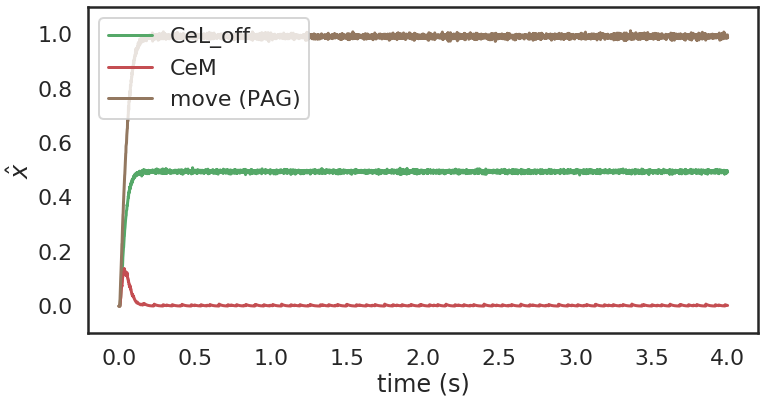

(0.99223792115947, 0.9923249544863773, 0.9923496865736706, 0.992238768102942)

In [5]:
pre_control()

### Activation of CeM induces spontaneous freezing
Optogenetically activating CeM neurons elicits freezing (Ciocchi et al., 2010). Since CeM expresses vasopressin receptors (Huber et al. 2015), application of this neuropeptide should have a similar effect (look for citation).

In [6]:
def pre_muscimol_CeM(plot=True):

    t_test = 4
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]
    CeM_func = lambda t: 1.4

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, CeM_func=CeM_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
#         ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
#         ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
#         ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        ax.legend()
        plt.savefig('plots/pre_muscimol_CeM.svg')
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

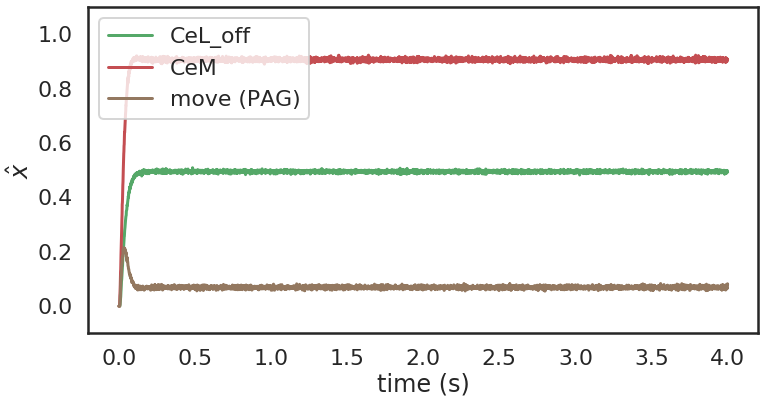

(0.06894708381515892,
 0.06903178685948809,
 0.0690303261859447,
 0.06897068549473594)

In [7]:
pre_muscimol_CeM()

### Inctivation of CeL induces spontaneous freezing
GABA_A receptor agonist (muscimol-bodipy (BPY)) applied to CeL alone induced spontaneous freezing (Ciocchi et al, 2010)

In [8]:
def pre_muscimol_CeL(plot=True):

    t_test = 4
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]
    CeL_func = lambda t: -1

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, CeL_func=CeL_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
#         ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
#         ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
#         ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        ax.legend()
        plt.savefig('plots/pre_muscimol_CeL.svg')
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

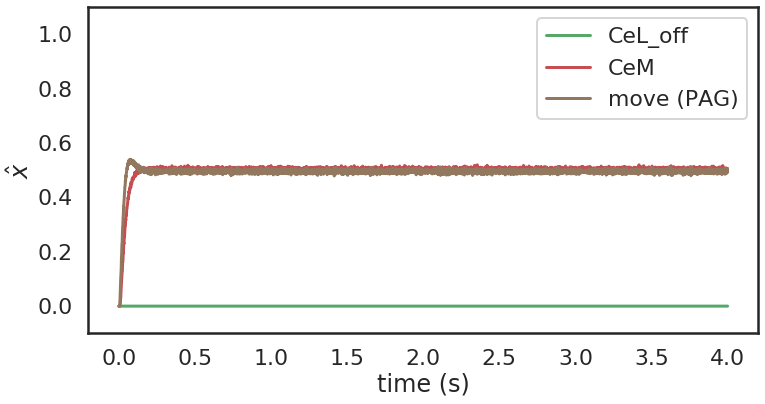

(0.49540697135743267,
 0.4954064666583603,
 0.49539556107174687,
 0.49537712416580076)

In [9]:
pre_muscimol_CeL()

## During training experiments

### Control

In [10]:
def condition_control(plot=True):

    t_condition = 40
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/condition_control_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/condition_control_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/pduggins/.local/share/virtualenvs/anatomical_amygdala--T40zd3z/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


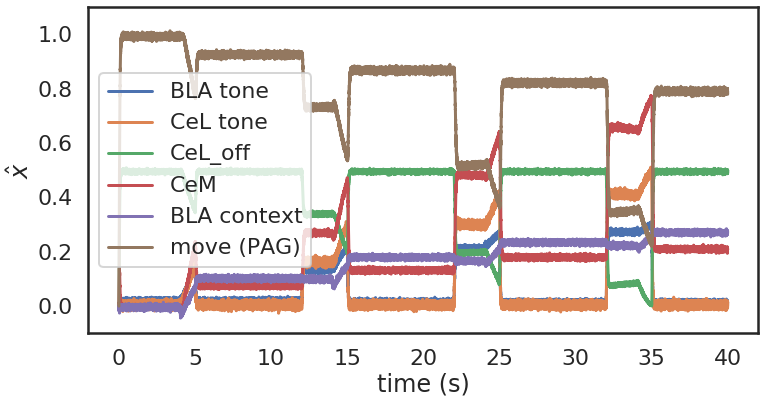

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

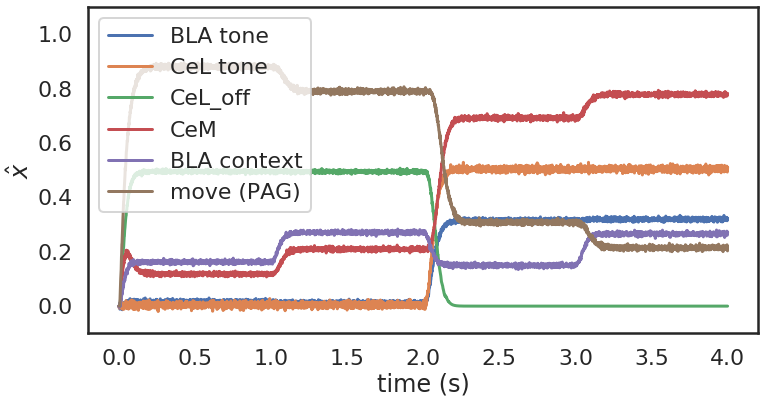

(0.8809592521666376,
 0.7902552203836543,
 0.30845252112227706,
 0.21476544187390575)

In [11]:
condition_control()

### Inactivation of CeL during training impairs fear conditioning
Muscimol (Ciocchi et al., 2010)

In [12]:
def muscimol_CeL_condition(plot=True):

    t_condition = 40
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    CeL_func = lambda t: -1

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, CeL_func=CeL_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_CeL_condition_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_CeL_condition_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

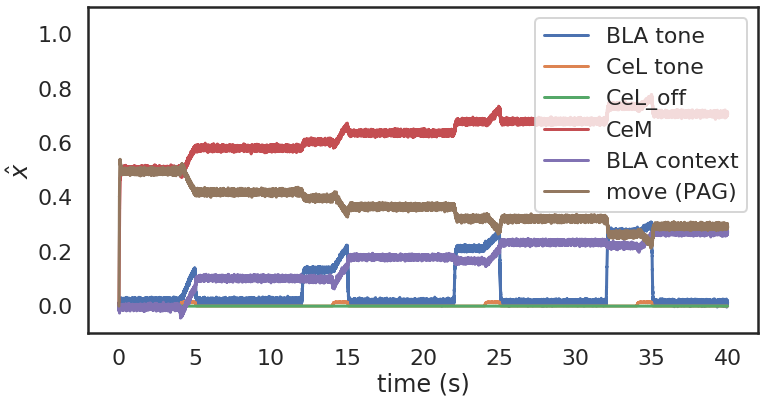

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

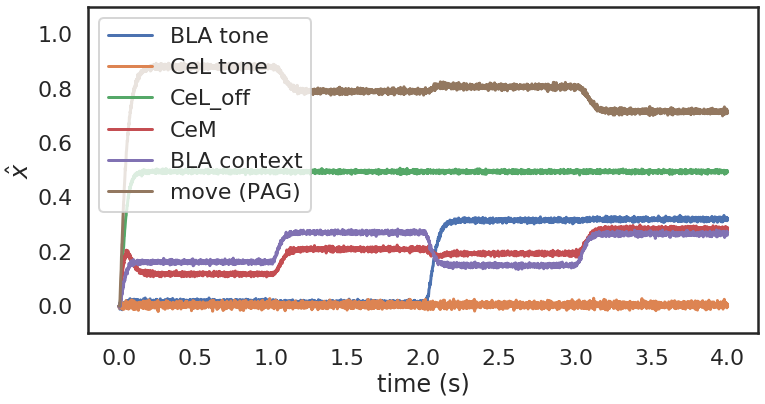

(0.8809592521666376,
 0.7902552203836543,
 0.8070267550827361,
 0.7164599603160074)

In [13]:
muscimol_CeL_condition()

### Applying oxytocin to CeL during conditioning does not affect learning
Viviani et al., 2011

In [14]:
def oxytocin_CeL_condition(plot=True):

    t_condition = 40
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    CeL_off_func = lambda t: -1

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, CeL_off_func=CeL_off_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/oxytocin_CeL_condition_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/oxytocin_CeL_condition_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

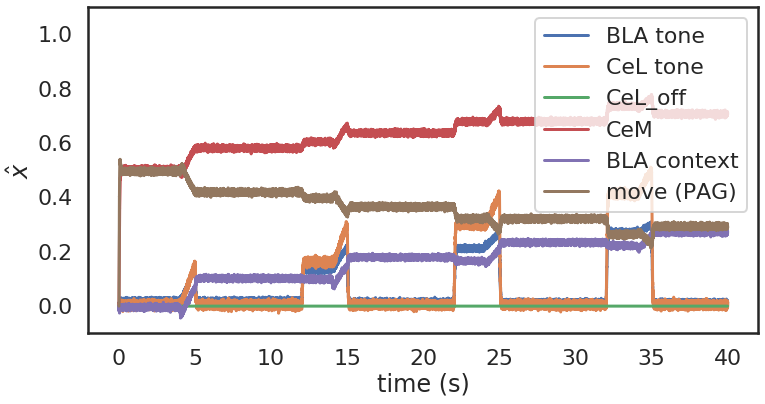

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

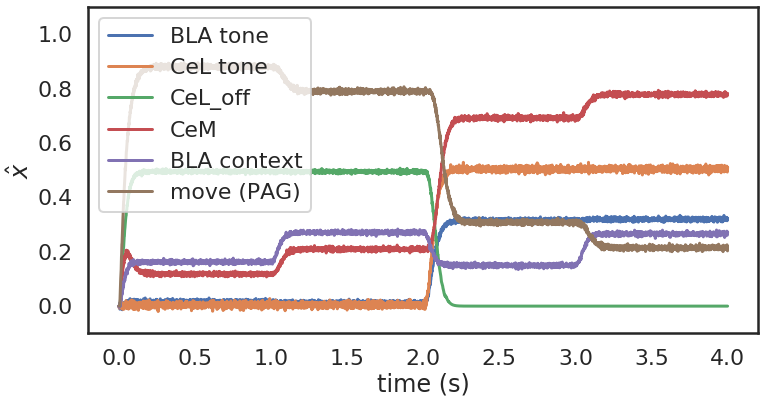

(0.8809592521666376,
 0.7902552203836543,
 0.30845252112227706,
 0.21476544187390575)

In [15]:
oxytocin_CeL_condition()

### Inactivation of GABAergic interneurons in BLA facilitates fear conditoning
Dopamine and Norepinephrine are natural neuromodulators of inhibition in BLA, and their presence is implicated in the aquisition of conditioned fear (Bush et al., 2010; Greba et al., 2001; Guarraci et al., 1999; Nader and LeDoux, 1999)

In [16]:
def dopamine_BLA_condition(plot=True):

    t_condition = 40
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    BLA_func = lambda t: 0

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, BLA_func=BLA_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/dopamine_BLA_condition_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/dopamine_BLA_condition_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

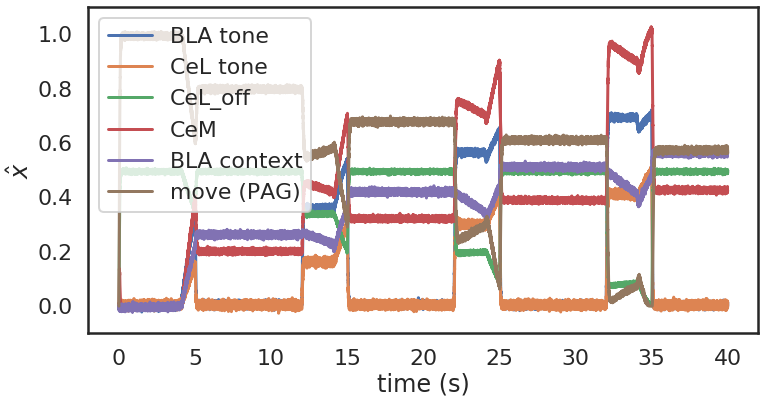

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

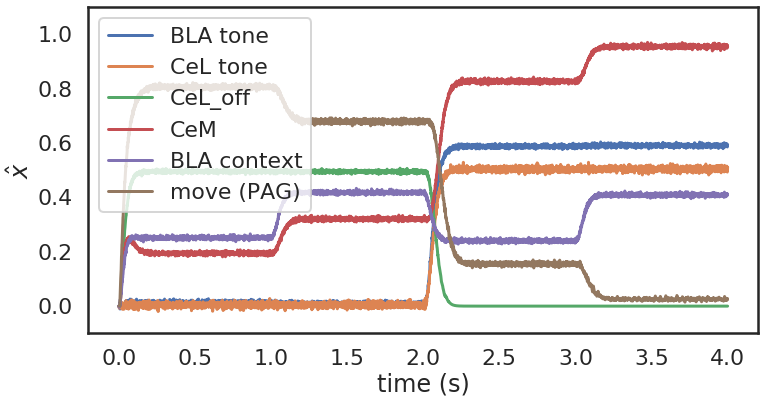

(0.8063042518514787,
 0.6790796740817502,
 0.15549614714156096,
 0.025313046992096)

In [17]:
dopamine_BLA_condition()

### Activation of GABAergic interneurons in BLA impairs fear conditoning
Serotonin is a natural neuromodulators of inhibition in BLA, and its presence is implicated in constraining synaptic plasticity in LA (Shumyatsky et al., 2002). Applying muscimol to BLA mimics these dampening effects and reduces fear conditioning (Muller et al. 1997). 

In [18]:
def seratonin_BLA_condition(plot=True):

    t_condition = 40
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    BLA_func = lambda t: 1.0

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, BLA_func=BLA_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/seratonin_BLA_condition_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/seratonin_BLA_condition_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

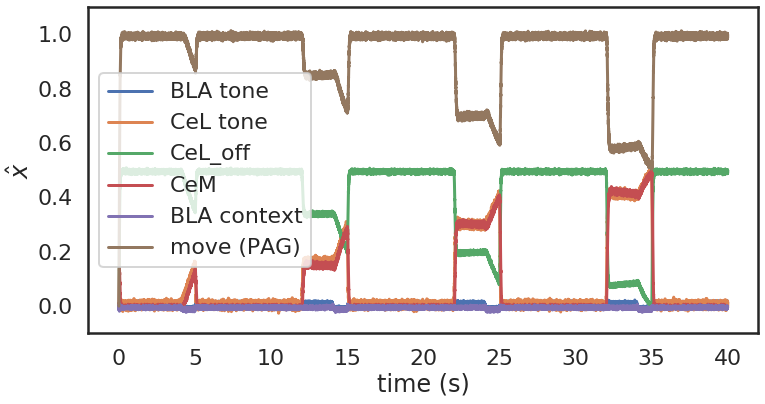

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

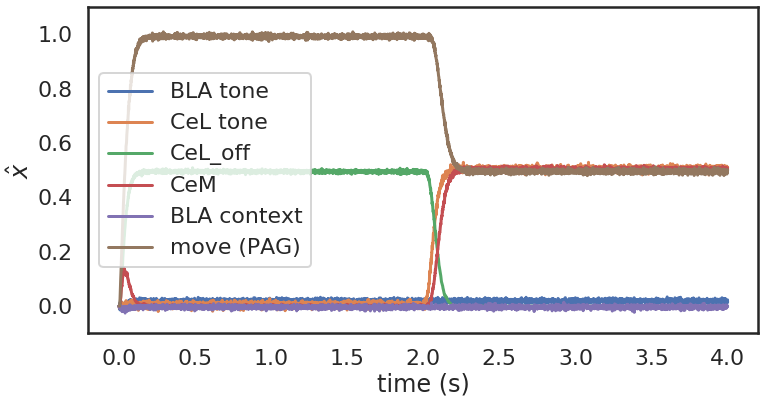

(0.99223792115947, 0.9923249544863773, 0.4957382099312667, 0.4955067167862586)

In [19]:
seratonin_BLA_condition()

In [35]:
def muscimol_BLA_condition(plot=True):

    t_condition = 40
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))
    BLA_musc_func = lambda t: -1.0

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, BLA_musc_func=BLA_musc_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_BLA_condition_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_BLA_condition_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

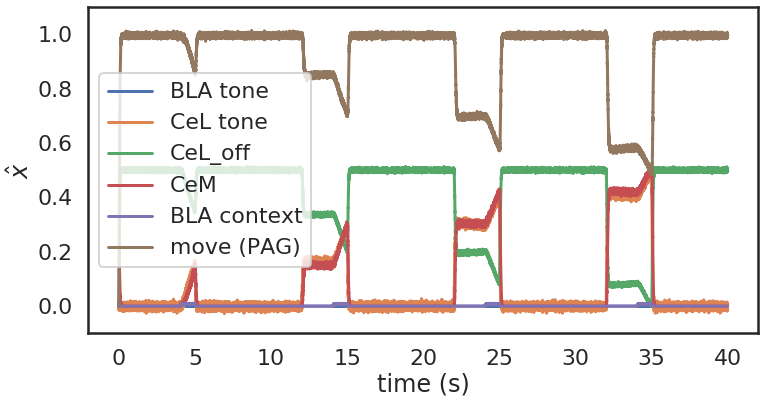

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

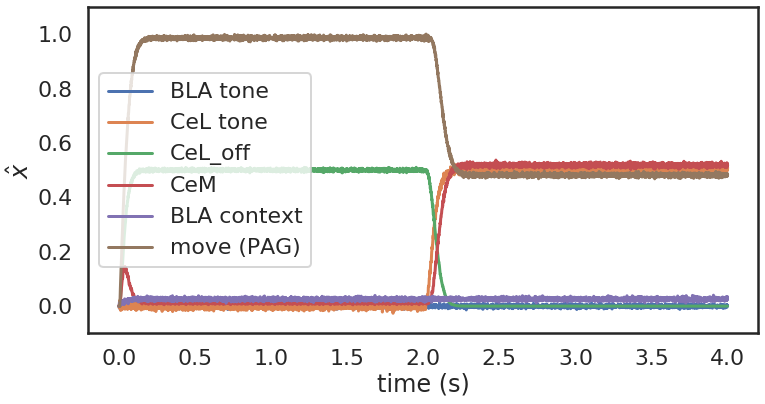

(0.9867609080193559, 0.9867117544721036, 0.482250460791784, 0.481882856464905)

In [36]:
muscimol_BLA_condition()

## Extinction

### control

In [20]:
def extinction_control(plot=True):

    t_condition = 40
    t_extinct = 100
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/extinction_control_train.svg')
        ax.legend()
        plt.show()

    tones, shocks = make_US_CS_arrays(pairings=1+int(t_extinct/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1]

    data = go(t_extinct, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/extinction_control_train2.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/extinction_control_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

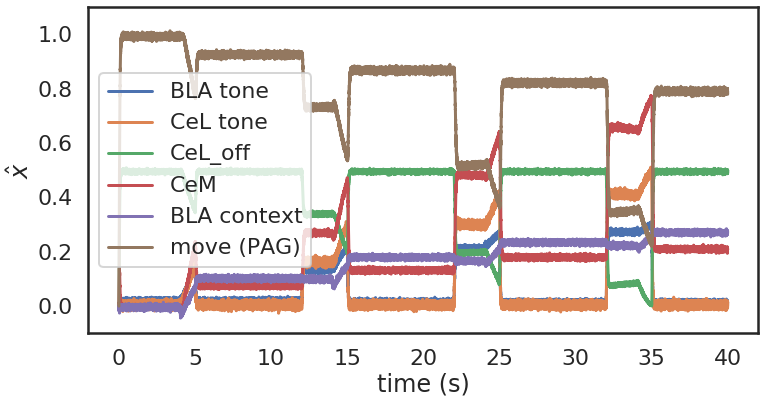

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

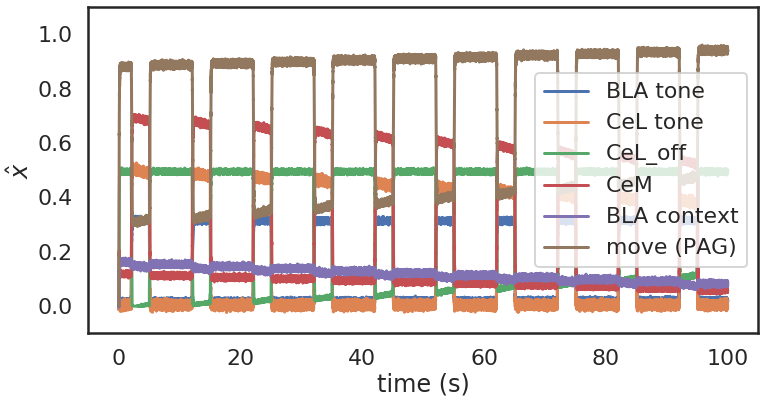

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

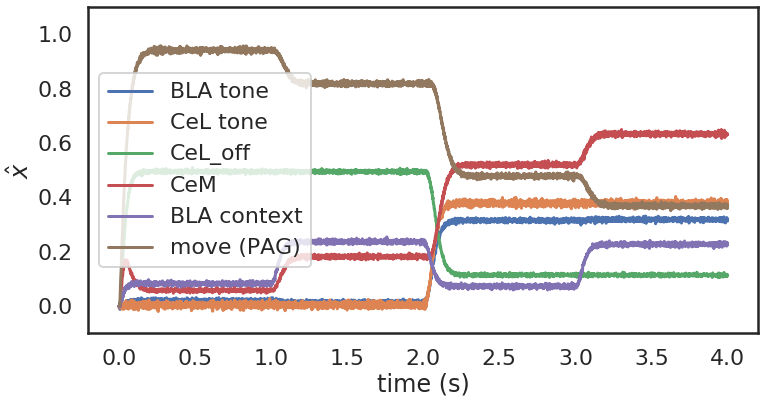

(0.9415385111824062,
 0.8184940522489362,
 0.47899035988529626,
 0.36873896204408174)

In [21]:
extinction_control()

### Inactivation of BLA impairs extinction
Sierra-Mercado et al., 2011

In [39]:
def muscimol_BLA_extinction(plot=True):

    t_condition = 40
    t_extinct = 100
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_BLA_extinction_train.svg')
        ax.legend()
        plt.show()

    tones, shocks = make_US_CS_arrays(pairings=1+int(t_extinct/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1]
    BLA_musc_func = lambda t: -1

    data = go(t_extinct, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, BLA_musc_func=BLA_musc_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_BLA_extinction_train2.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/muscimol_BLA_extinction_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

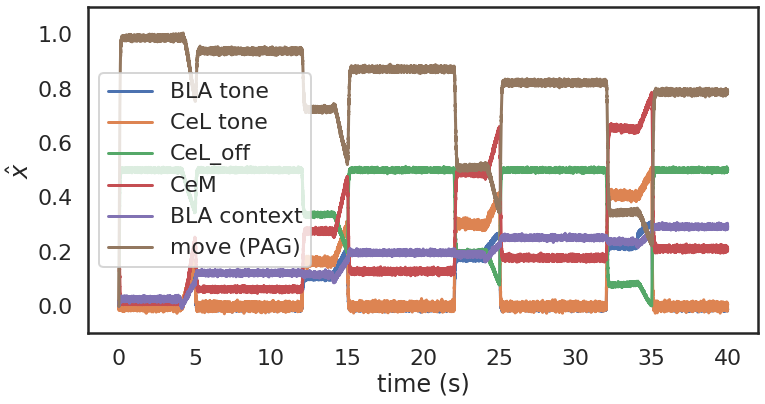

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

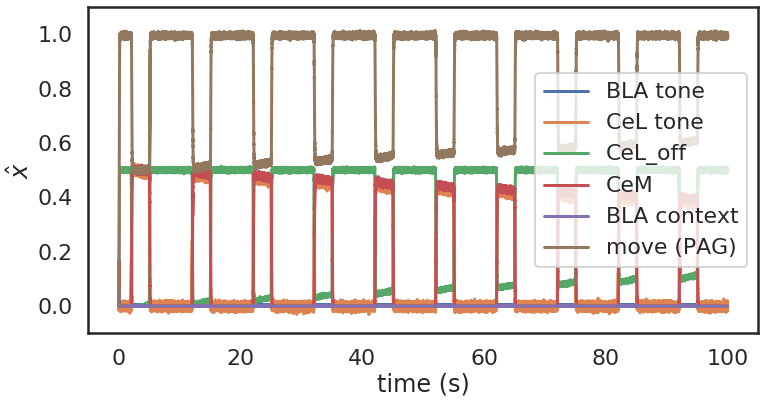

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

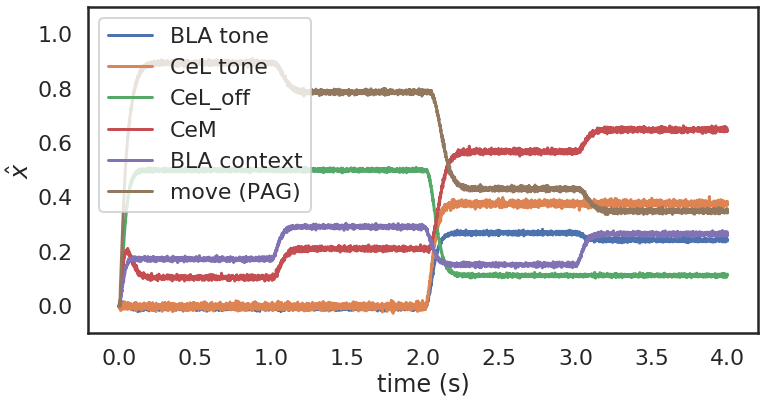

(0.8945385062692122,
 0.7875525223809701,
 0.4319263883277669,
 0.34939626599120427)

In [40]:
muscimol_BLA_extinction()

## Post-training

### Applying oxytocin during testing reduces conditioned fear
Viviani et al. 2011

In [24]:
def condition_oxytocin_CeL(plot=True):

    t_condition = 40
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/condition_oxytocin_CeL_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]
    CeL_off_func = lambda t: 1

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, CeL_off_func=CeL_off_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/condition_oxytocin_CeL_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

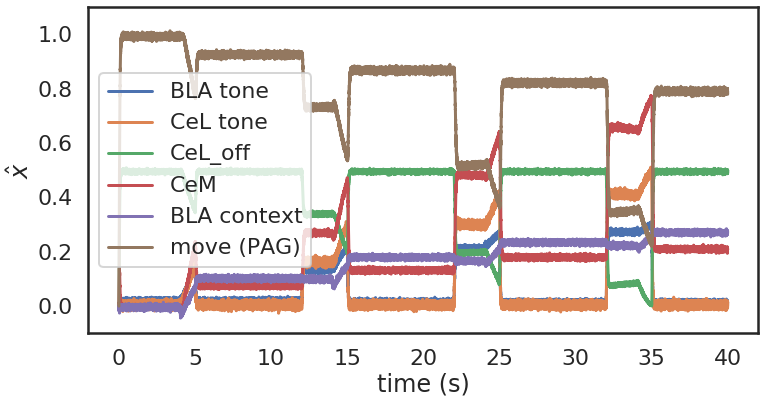

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

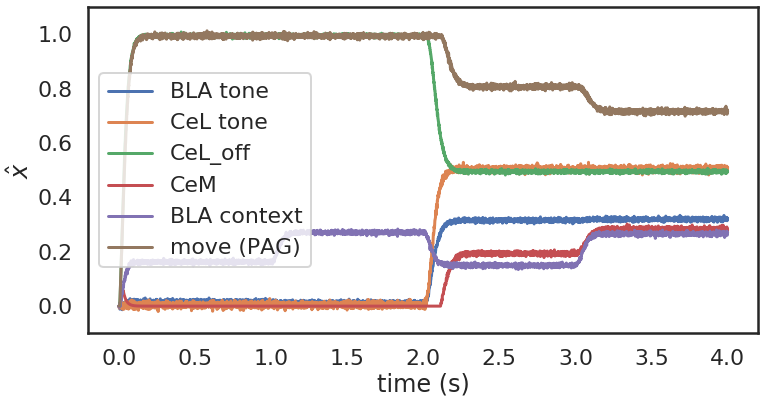

(0.993783166723997, 0.9938148049271464, 0.8076905788303714, 0.7164451965659528)

In [25]:
condition_oxytocin_CeL()

### Inactivating BLA during testing reduces conditioned fear
Muller et al., 1997

In [26]:
def condition_muscimol_BLA(plot=True):

    t_condition = 40
    t_test = 4
    dt = 0.001
    tones, shocks = make_US_CS_arrays(pairings=1+int(t_condition/10), seed=0)
    tone_func = lambda t: tones[int(t/dt)]
    shock_func = lambda t: shocks[int(t/dt)]
    context_func = lambda t: [1, 0]
    d_thal_CeL = np.zeros((200, 1))
    d_cortex_BLA = np.zeros((200, 1))
    d_hippo_BLA = np.zeros((400, 1))

    data = go(t_condition, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func)

    d_thal_CeL = data['thal_CeL']
    d_cortex_BLA = data['cortex_BLA']
    d_hippo_BLA = data['hippo_BLA']

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/condition_muscimol_BLA_train.svg')
        ax.legend()
        plt.show()

    tone_func = lambda t: 0 if (0<t<2) else 1
    shock_func = lambda t: 0
    context_func = lambda t: [0, 1] if (0<t<1 or 2<t<3) else [1, 0]
    BLA_func = lambda t: 1.0

    data = go(t_test, d_thal_CeL, d_cortex_BLA, d_hippo_BLA, tone_func, shock_func, context_func, BLA_func=BLA_func, learning=False)

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(data['times'], data['BLA'][:,0], label='BLA tone', color=palette[0])
        ax.plot(data['times'], data['CeL'][:,0], label='CeL tone', color=palette[1])
        ax.plot(data['times'], data['CeL_off'], label='CeL_off', color=palette[2])
        ax.plot(data['times'], data['CeM'], label='CeM', color=palette[3])
        ax.plot(data['times'], data['BLA'][:,2], label='BLA context', color=palette[4])
        ax.plot(data['times'], data['PAG'], label='move (PAG)', color=palette[5])
        ax.set(xlabel='time (s)', ylabel=r'$\hat{x}$', ylim=((-0.1, 1.1)))
        plt.savefig('plots/condition_muscimol_BLA_test.svg')
        ax.legend()
        plt.show()

    neither = np.average(data['PAG'][250:750])
    context = np.average(data['PAG'][1250:1750])
    tone = np.average(data['PAG'][2250:2750])
    both = np.average(data['PAG'][3250:3750])
    return neither, context, tone, both

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

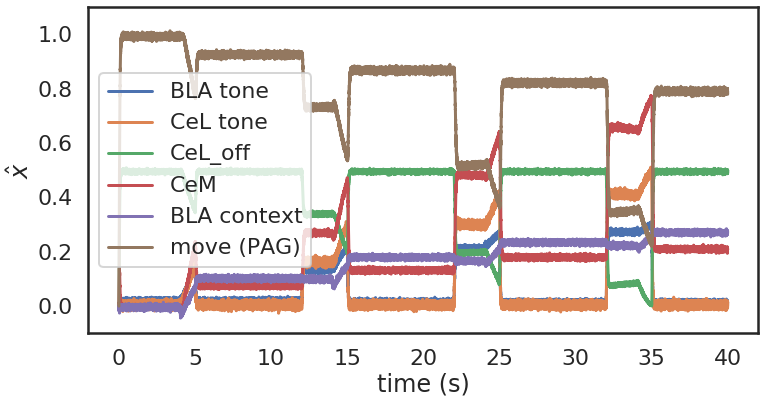

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

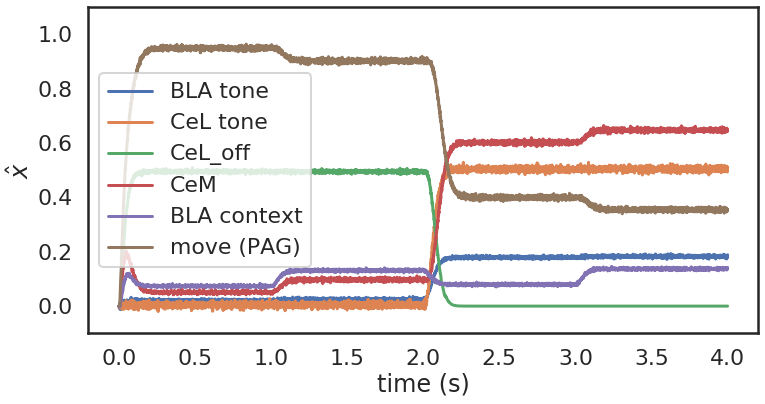

(0.9492128282896453,
 0.9021397987607055,
 0.39983022545940733,
 0.35468933000833175)

In [27]:
condition_muscimol_BLA()

# Data Collection

In [41]:
nrmses = {
    'pre_control': [],
    'condition_control': [],
    'extinction_control': [],      
    'pre_muscimol_CeM': [],
    'pre_muscimol_CeL': [],
    'muscimol_CeL_condition': [],
    'muscimol_BLA_condition': [],
    'muscimol_BLA_extinction': [],
    'condition_muscimol_BLA': [],
    'condition_oxytocin_CeL': [],          
    'oxytocin_CeL_condition': [],
    'dopamine_BLA_condition': [],
    'seratonin_BLA_condition': []}

n_trials = 1
for n in range(n_trials):
    # 0=neither, 1=context, 2=tone, 3=both
    nrmses['pre_control'].append(pre_control(plot=False)[2])
    nrmses['condition_control'].append(condition_control(plot=False)[2])
    nrmses['extinction_control'].append(extinction_control(plot=False)[2])
    nrmses['pre_muscimol_CeM'].append(pre_muscimol_CeM(plot=False)[2])
    nrmses['pre_muscimol_CeL'].append(pre_muscimol_CeL(plot=False)[1])
    nrmses['muscimol_CeL_condition'].append(muscimol_CeL_condition(plot=False)[2])
    nrmses['muscimol_BLA_condition'].append(muscimol_BLA_condition(plot=False)[2])
    nrmses['muscimol_BLA_extinction'].append(muscimol_BLA_extinction(plot=False)[2])
    nrmses['condition_muscimol_BLA'].append(condition_muscimol_BLA(plot=False)[2])
    nrmses['condition_oxytocin_CeL'].append(condition_oxytocin_CeL(plot=False)[1])
    nrmses['oxytocin_CeL_condition'].append(oxytocin_CeL_condition(plot=False)[2])
    nrmses['dopamine_BLA_condition'].append(dopamine_BLA_condition(plot=False)[2])
    nrmses['seratonin_BLA_condition'].append(seratonin_BLA_condition(plot=False)[2])
    
np.savez('data.npz', 
    pre_control=np.array(nrmses['pre_control']),
    condition_control=np.array(nrmses['condition_control']),
    extinction_control=np.array(nrmses['extinction_control']),
    pre_muscimol_CeM=np.array(nrmses['pre_muscimol_CeM']),
    pre_muscimol_CeL=np.array(nrmses['pre_muscimol_CeL']),
    muscimol_CeL_condition=np.array(nrmses['muscimol_CeL_condition']),
    muscimol_BLA_condition=np.array(nrmses['muscimol_BLA_condition']),
    muscimol_BLA_extinction=np.array(nrmses['muscimol_BLA_extinction']),
    condition_muscimol_BLA=np.array(nrmses['condition_muscimol_BLA']),
    condition_oxytocin_CeL=np.array(nrmses['condition_oxytocin_CeL']),
    oxytocin_CeL_condition=np.array(nrmses['oxytocin_CeL_condition']),
    dopamine_BLA_condition=np.array(nrmses['dopamine_BLA_condition']),
    seratonin_BLA_condition=np.array(nrmses['seratonin_BLA_condition']),
    )

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
nrmses

In [ ]:
# nrmses = {'pre_control': [0.9923496865736706],
#  'condition_control': [0.30845252112227706],
#  'extinction_control': [0.47899035988529626],      
#  'pre_muscimol_CeM': [0.0690303261859447],
#  'pre_muscimol_CeL': [0.49539556107174687],
#  'muscimol_CeL_condition': [0.8070267550827361],
#  'muscimol_BLA_condition': [0.49573820993126677],
#  'muscimol_BLA_extinction': [0.4237786566269982],
#  'condition_muscimol_BLA': [0.3998302254594072],
#  'condition_oxytocin_CeL': [0.8076905788303714],          
#  'oxytocin_CeL_condition': [0.30845252112227706],
#  'dopamine_BLA_condition': [0.15549614714156096],
#  'seratonin_BLA_condition': [0.49573820993126677]}

In [ ]:
names = []
values = []
# for key, value in sorted(nrmses.items(), key=lambda item: item[1]):
for key, value in nrmses.items():
    names.append(key)
    values.append(value)
# labels = (names)
labels = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N')
values = np.array(values).ravel()

In [ ]:
# with sns.color_palette("cubehelix", 14):
with sns.color_palette(sns.hls_palette(13, l=0.4, s=0.8)):
    fig, ax = plt.subplots(figsize=((14, 6)))
    sns.barplot(names, values, ax=ax)
    ax.set(ylabel='move', ylim=((0, 1.1)))
    ax.set_xticklabels(labels)
    plt.savefig('plots/results.svg')
    plt.show()